## Simulation as Optimization: Finding Paths of Least Action with Gradient Descent
Tim Strang and Sam Greydanus | 2023 | MIT License

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch, time

from celluloid import Camera
from IPython.display import HTML
from base64 import b64encode

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from main import * # SimOpt code

In [5]:
def plot_action_stats(ax, S, T, V, S_ode, T_ode, V_ode):
    alpha = .7
    plot_config = [(S, 'k', '$S$', alpha), (T, 'r', '$\sum_i T_i$', alpha),
                   (-np.asarray(V), 'b', '$-\sum_i V_i$', alpha),
                   (S_ode, 'k:', '$S$ (ODE)', 1), (T_ode, 'r:', '$-\sum_i T_i$ (ODE)', 1),
                   (-V_ode, 'b:', '$-\sum_i V_i$ (ODE)', 1)]
    N = len(S)
    for i, (x, fmt, label, alpha) in enumerate(plot_config):
        if i <= 2:
            ax.plot(np.arange(N), x, fmt, alpha=alpha, linewidth=4, label=label)
        else:
            ax.plot([0,N], [x]*2, fmt, alpha=alpha, linewidth=4, label=label)
            
def plot_helper(ax, ax_labels, fontsz, legend=False):
    #plt.title(ax_labels['title'], fontweight="bold")
    if legend:
        plt.legend(ncol=2, fontsize=fontsz['legend'])
    #plt.xlabel(ax_labels['x_label'])
    #plt.ylabel(ax_labels['y_label'])
    #ax.xaxis.label.set_fontsize(fontsz['x_label'])
    #ax.yaxis.label.set_fontsize(fontsz['y_label'])
    #ax.title.set_fontsize(fontsz['title'])
    ax.tick_params(axis='both', length=9, width=3, labelsize=15)
    plt.tight_layout()  # helps clean up plots sometimes
    
def action_plot(info, x_sim, name, fontsz, ax_labels, L_fn, legend=False, fig=None, ylim=(None, None)):
    fig = plt.figure(figsize=(6, 5.5), dpi=DPI)
    ax = fig.add_subplot(111)
    S_ode, T_ode, V_ode = action(torch.tensor(x_sim), L_fn=L_fn, dt=dt)
    plot_action_stats(ax, info['S'], info['T'], info['V'], S_ode.sum(), T_ode.sum(), V_ode.sum())
    plt.ylim(ylim[0], ylim[1])
    path ='./static/{}_action.pdf'.format(name.lower().replace(' ', ''))
    plot_helper(ax, ax_labels, fontsz, legend=legend)
    plt.show() ; fig.savefig(path)

def unity(x):
    return x

def dynamic_plot(t_sim, x_sim, t_min, xs_min, name, fontsz, ax_labels, plt_fn=unity, ylim=(None, None)):
    fig = plt.figure(figsize=(7, 5), dpi=DPI) 
    ax = fig.add_subplot(111)
    ax.plot(t_sim, plt_fn(x_sim), color='purple', ls='-', label='ODE solution', linewidth=2)
    ax.scatter(t_sim, plt_fn(x_sim), color='purple', s=10)
    ax.plot(t_min, plt_fn(xs_min[0]), 'y.-', alpha=.3, label='Initial (random) path')
    for i, xi in enumerate(xs_min):
        label = 'During optimization' if i==10 else None
        ax.plot(t_min, plt_fn(xi), alpha=.3 + .7 * i/(len(xs_min)-1),
                color=plt.cm.viridis(1-i/(len(xs_min)-1)), label=label)
    ax.plot(t_min, plt_fn(xs_min[-1]), 'g.-', label='Final (optimized) path')
    ax.plot(t_min[[0,-1]], plt_fn(xs_min[0])[[0,-1]], 'g+', markersize=17, label='Points held constant')

    plt.ylim(ylim[0], ylim[1]+3)
    
    plot_helper(ax, ax_labels, fontsz, legend = name=='Free body')
    path ='./dynamic/{}.pdf'.format(name.lower().replace(' ', ''))
    plt.show() ; fig.savefig(path)
    

DPI=300

## Free body

In [6]:
dt = 0.25 ; N = 1 ; steps = 60
t_sim, x_sim = simulate_freebody(dt=dt, steps=steps)
init_path = PerturbedPath(x_sim, N=N, coords=1, sigma=1.5e0, zero_basepath=True) # [time, N*2]
t_min, path, xs_min, info = minimize_action(init_path, steps=550, step_size=1e0, 
                                       L_fn=lagrangian_freebody, dt=dt, opt='adam', verbose=False)

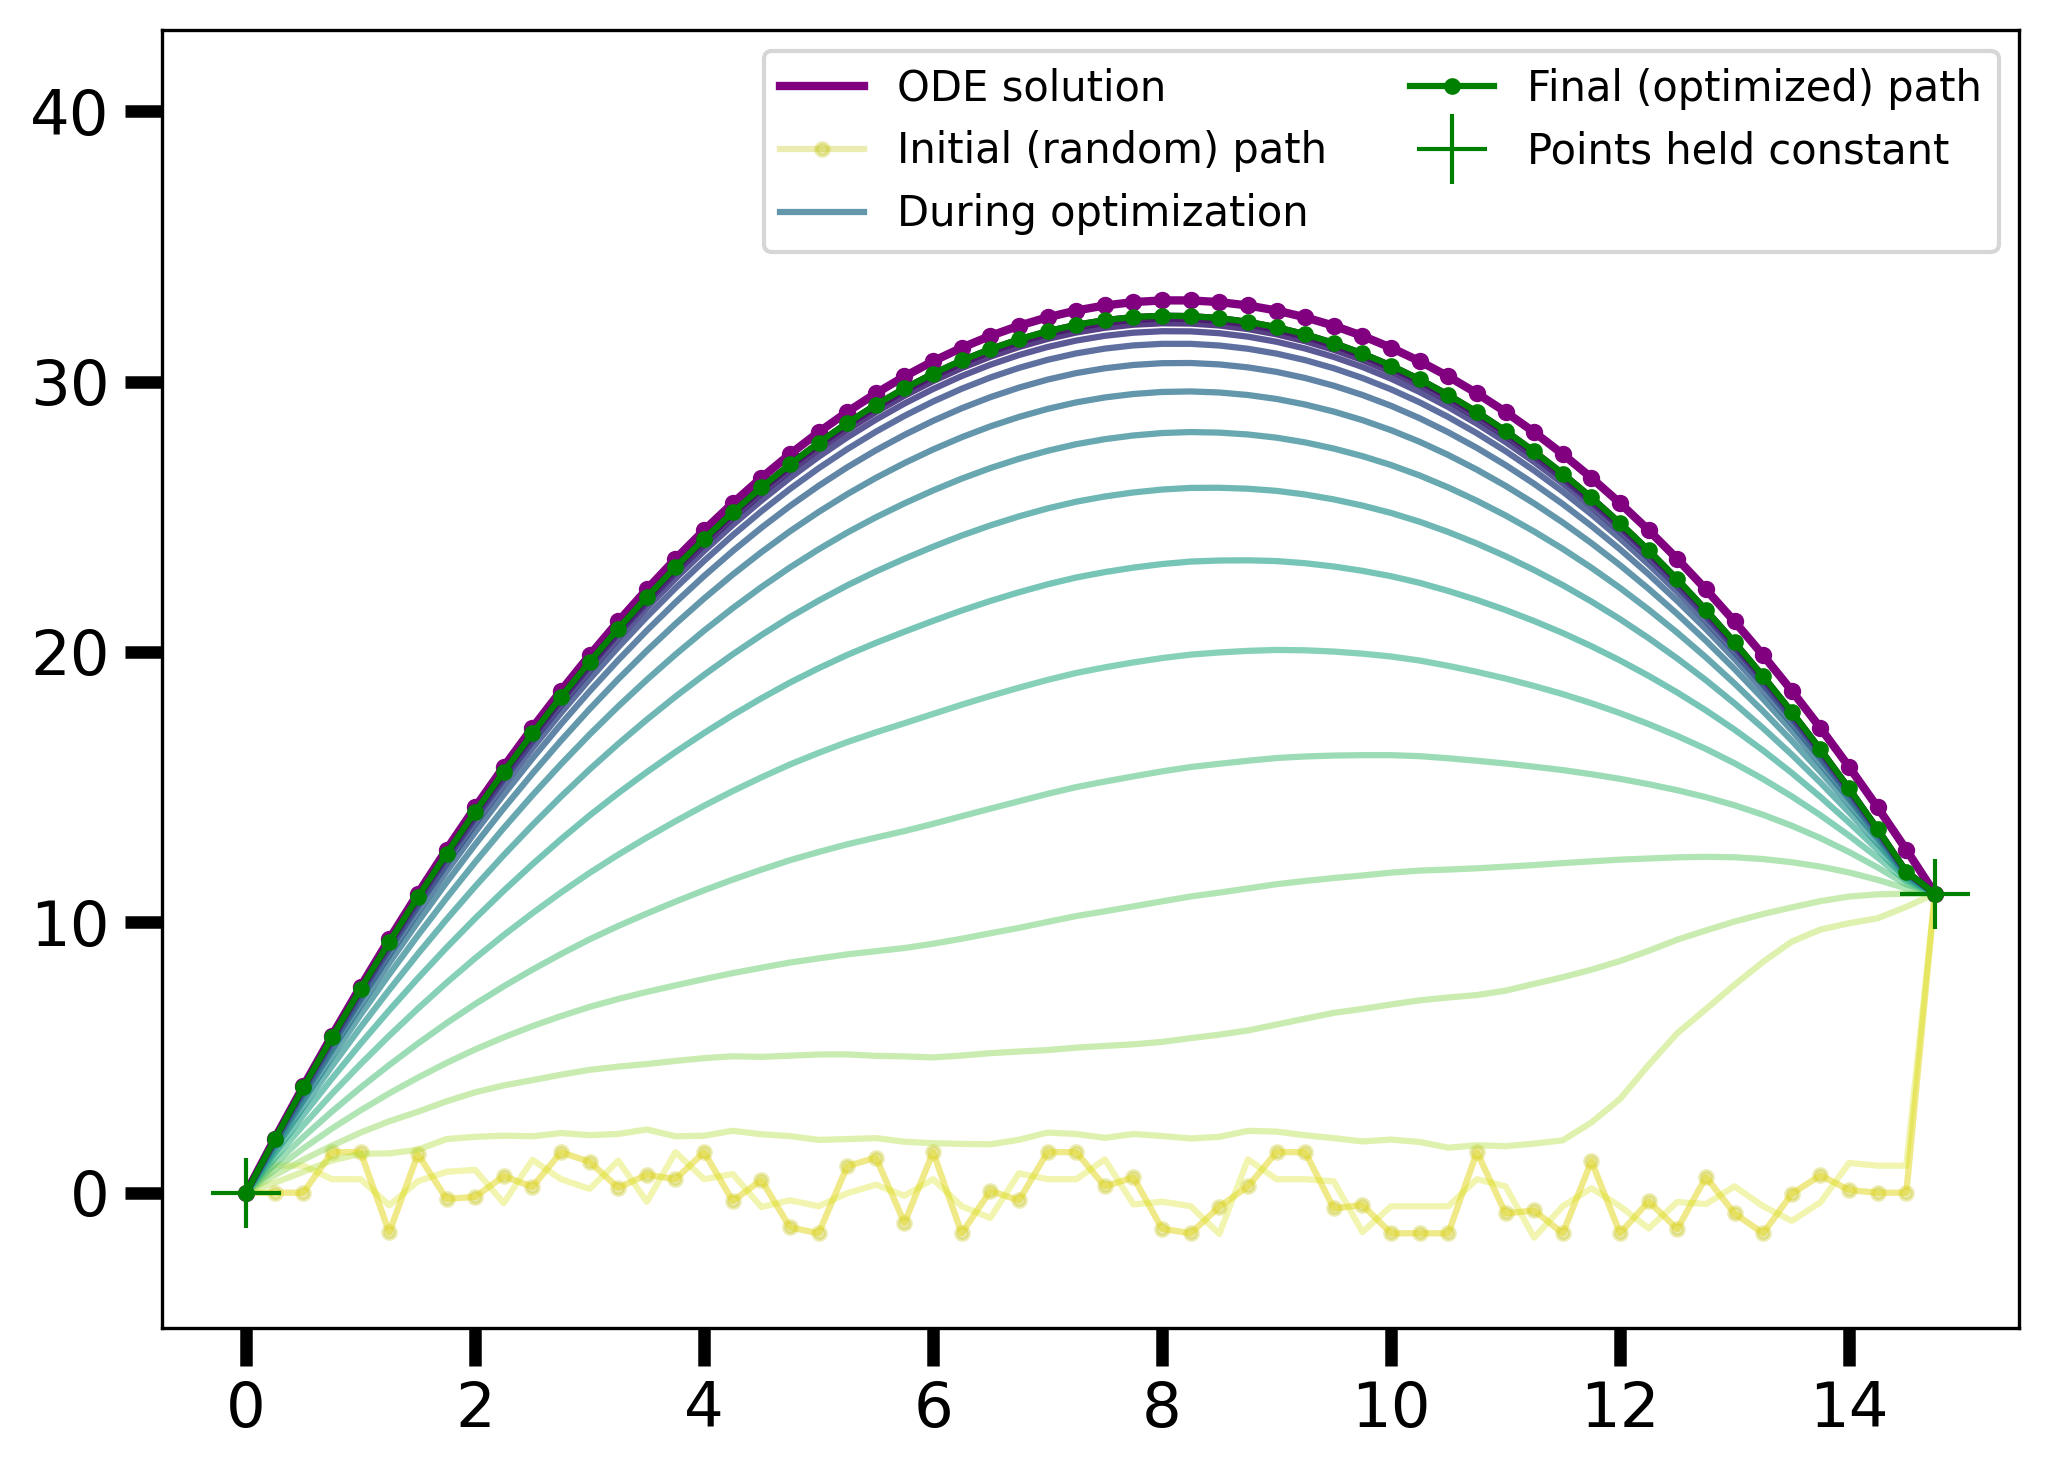

In [7]:
name = 'Free body'
fontsz = {'title': 23, 'x_label': 23, 'y_label': 23, 'legend': 10}
ax_labels = {'title':'Free Body Height vs Time',
             'x_label':'Time (s)', 'y_label':'Height (m)'}
dynamic_plot(t_sim, x_sim, t_min, xs_min, name, fontsz, ax_labels, ylim=(-5, 40))

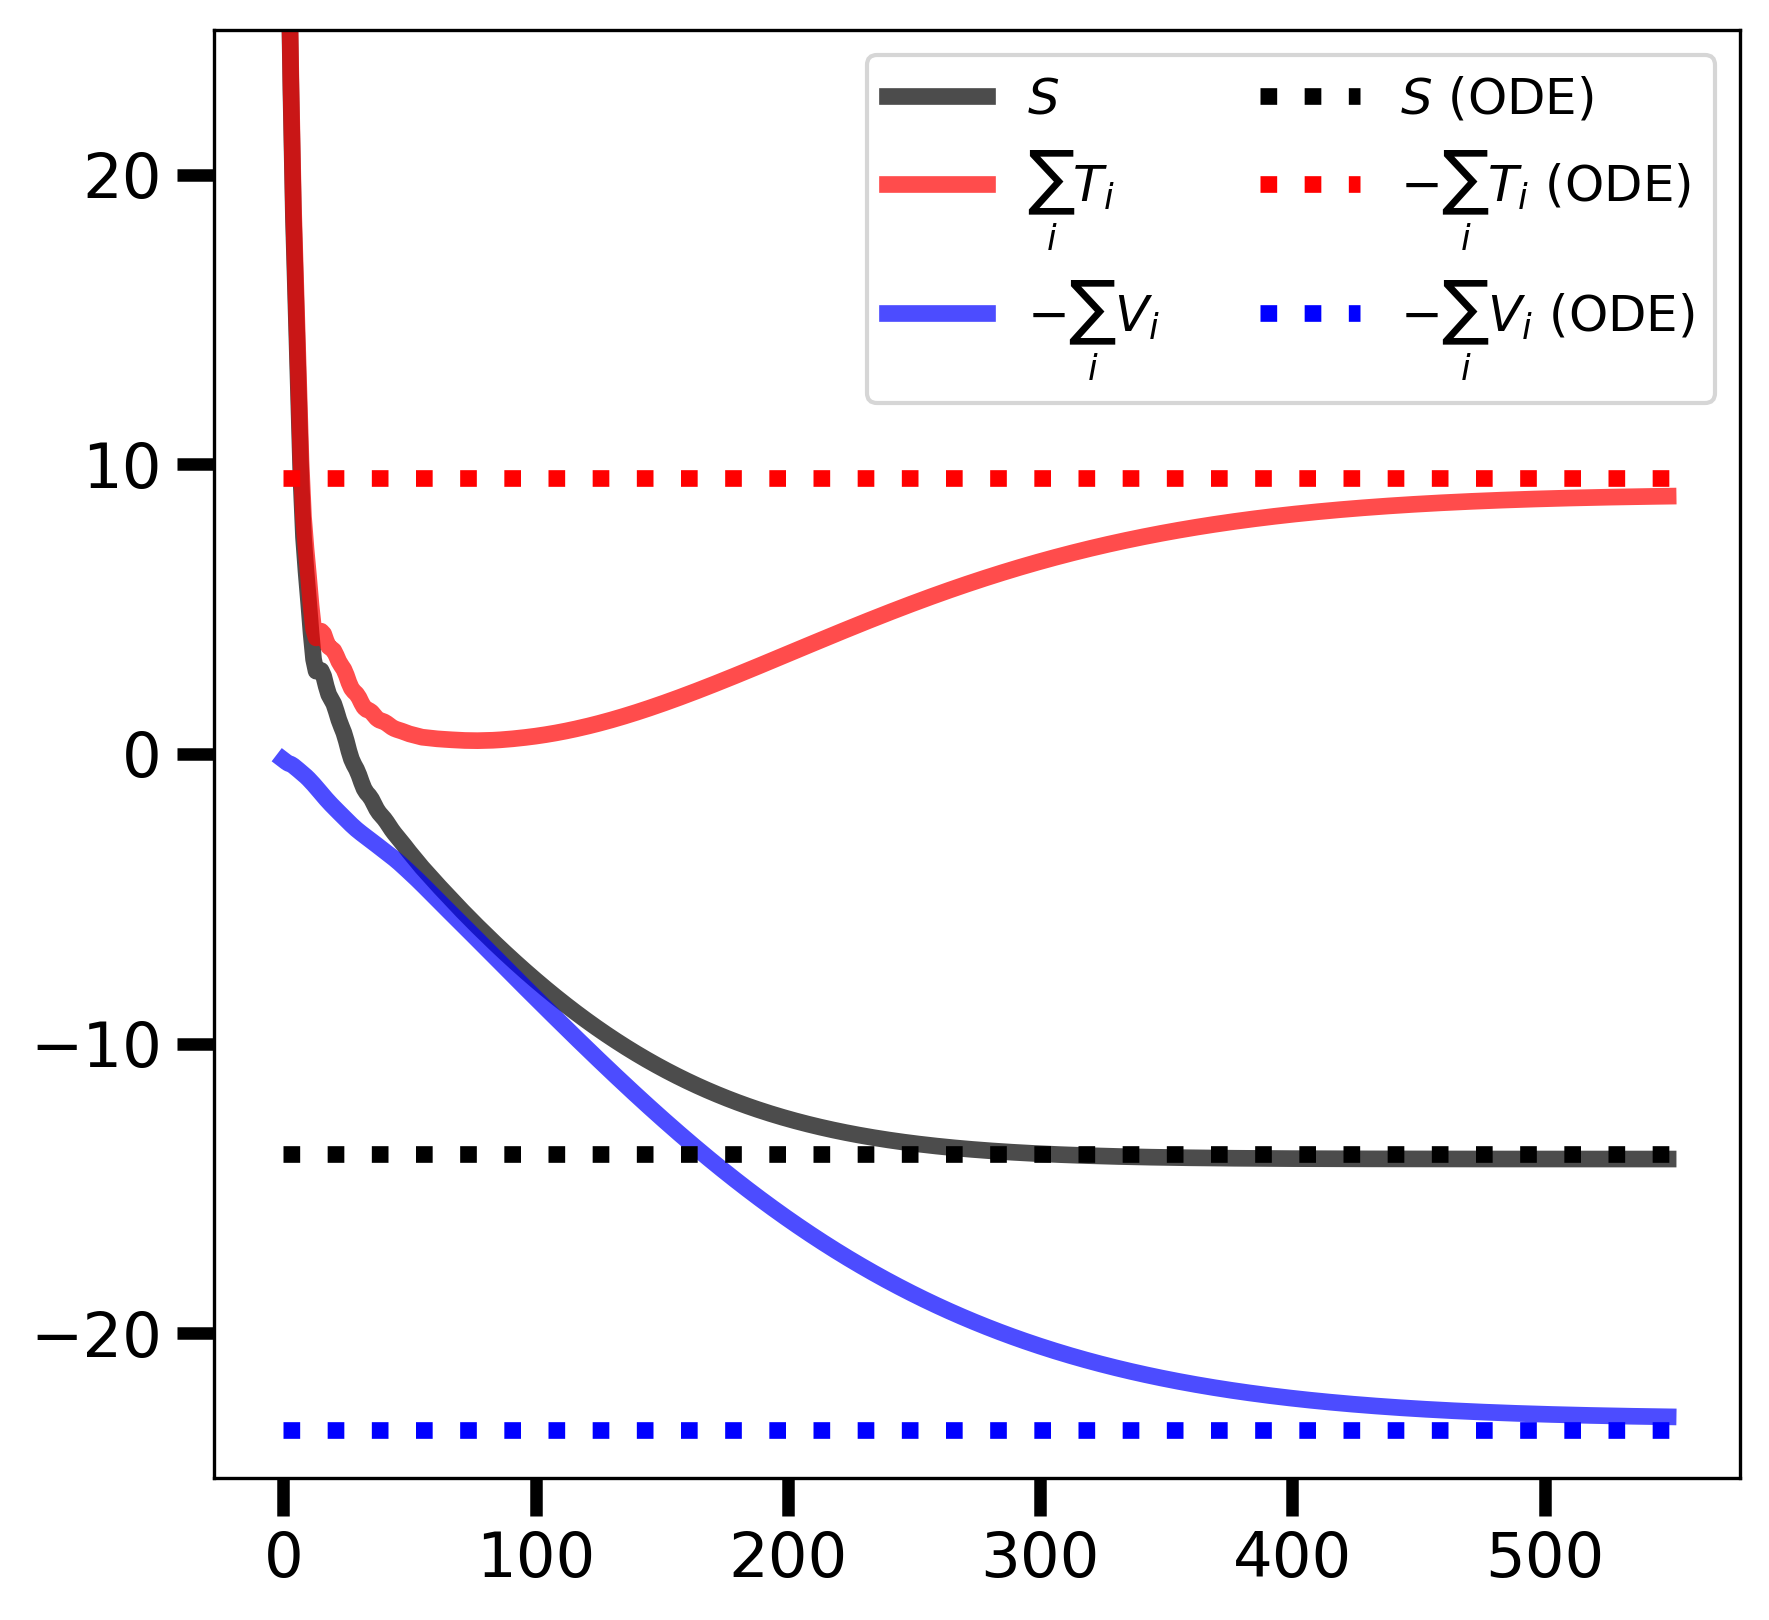

In [8]:
ax_labels = {'title':'Action and associated quantities ({})'.format(name),
                 'x_label':'Optimizer Steps', 'y_label':'J * s'}
fontsz = {'title': 17, 'x_label': 23, 'y_label': 28, 'legend': 12}
fig = action_plot(info, x_sim, name, fontsz, ax_labels, L_fn=lagrangian_freebody, legend=True, ylim=(-25, 25))

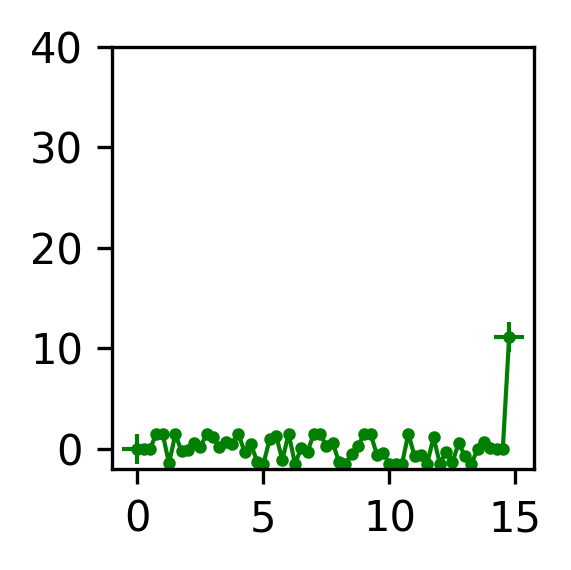

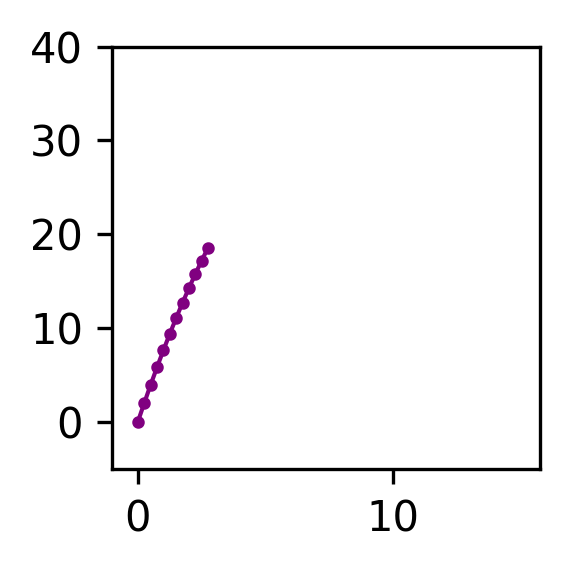

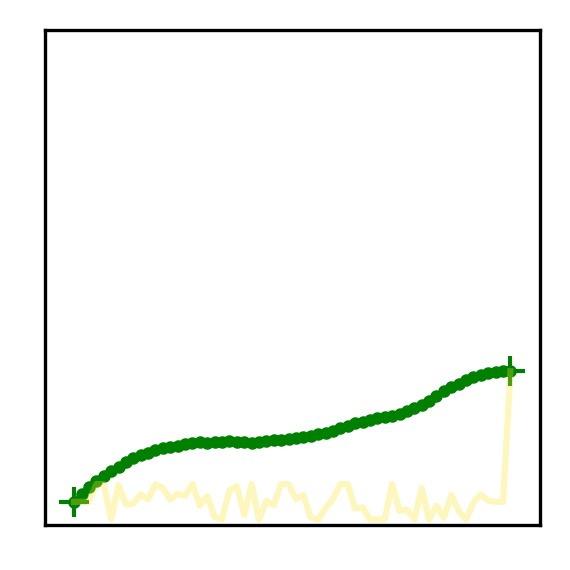

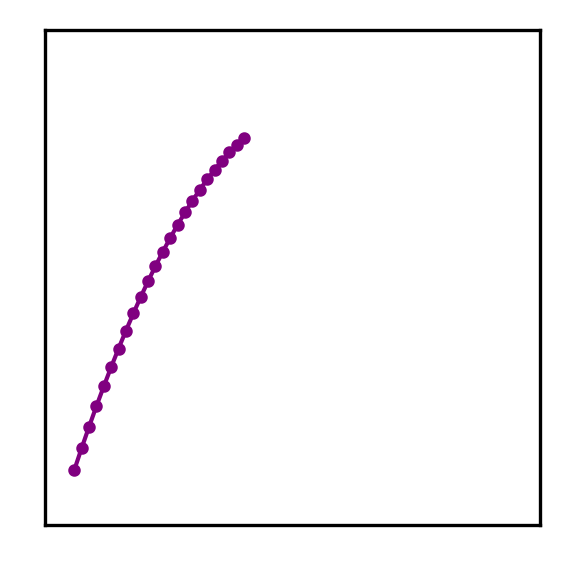

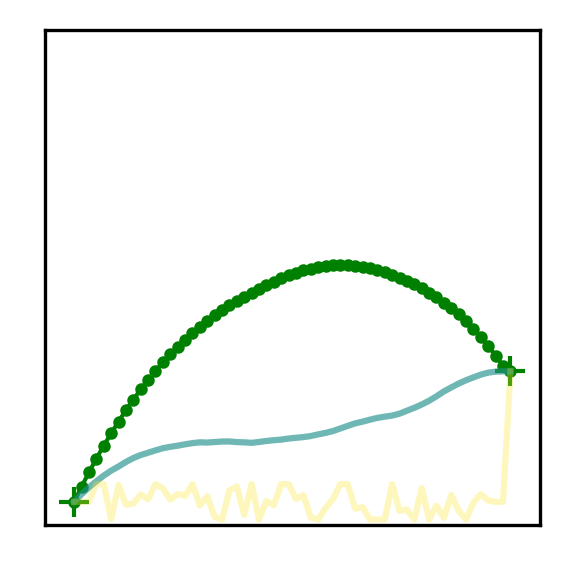

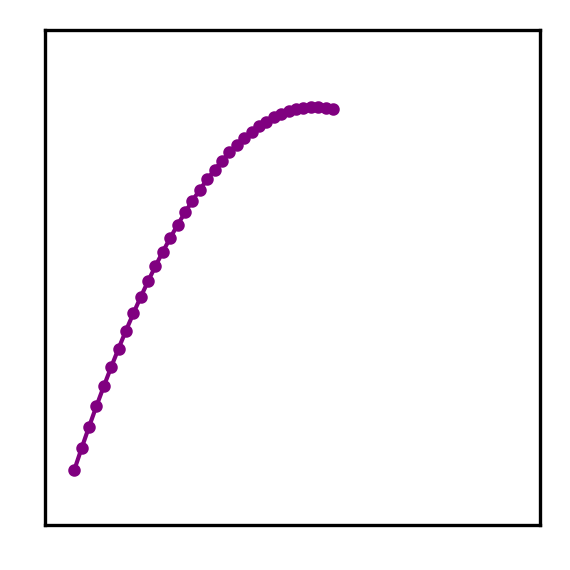

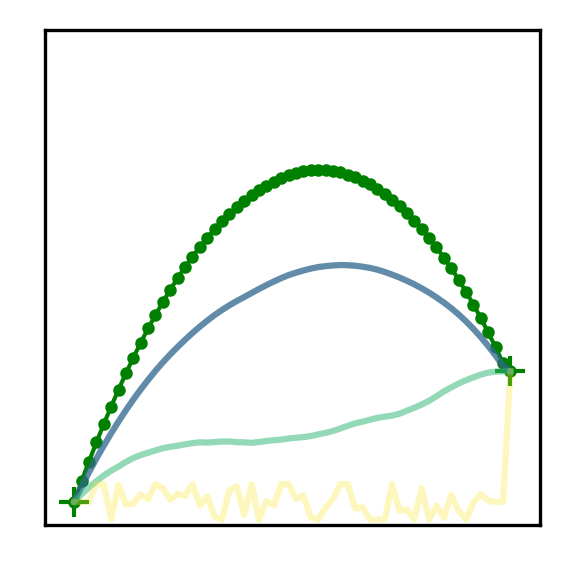

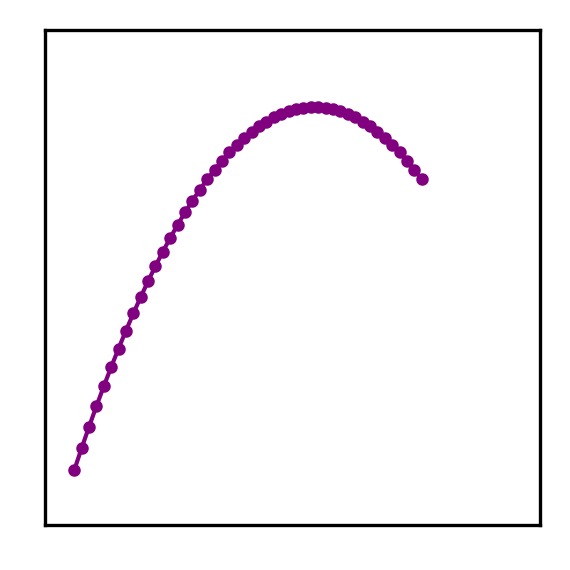

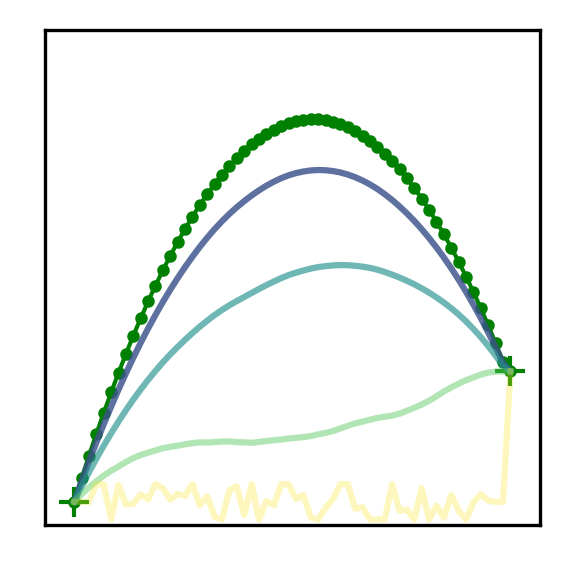

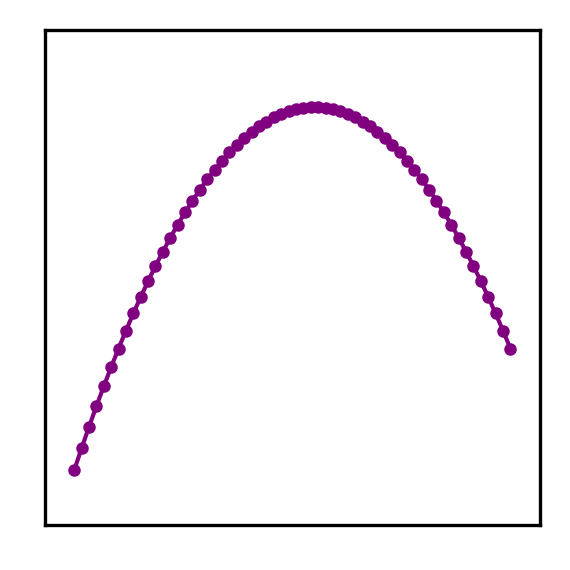

In [10]:
path = 'hero_plot'

def simplot(i, x_sim):
    M_sim = int(len(x_sim)/5)
    fig = plt.figure(figsize=(2, 2), dpi=DPI)
    ax=fig.add_subplot(111)
    j = i+1
    plt.scatter(t_sim[:j*M_sim], x_sim[:j*M_sim], color='purple', s=4)
    plt.plot(t_sim[:j*M_sim], x_sim[:j*M_sim], color='purple', linewidth=1)
    plt.xlim(-1, t_sim.max()+1)
    plt.ylim(-5, 40)
    if i != 0:
        plt.xticks([], []) ; plt.yticks([], []) # SJG comment - this approach works better
        #plt.tick_params(axis='y', labelcolor='w')
    
    plt.tight_layout()
    fig.savefig(path + f'/sim_{M_sim * j}.png')

def minplot(i, min_slice):
    fig = plt.figure(figsize=(2, 2), dpi=DPI)
    plt.scatter(t_min, xs_min[int(min_slice[i])], color='g', s=4)
    plt.plot(t_min, xs_min[int(min_slice[i])], 'g', linewidth=1)
    plt.xlim(-1, t_min.max()+1)
    plt.ylim(-2, 40)
    #plt.title(f'Step {min_slice[i]}', fontweight='bold')
    plt.plot(t_min[[0,-1]], xs_min[0].data[[0,-1]], 'g+', markersize=7)
    plt.xticks([0, 5, 10, 15])
    
    if i != 0:
        plt.xticks([], []) ; plt.yticks([], [])
            
    j = i
    while j>0:
        j = j-1
        slc= int(min_slice[j])
        plt.plot(t_min, xs_min[slc], alpha=.3 + .7*j/i, color=plt.cm.viridis(1-j/i))
    plt.tight_layout()
    fig.savefig(path + f'/min_{min_slice[i]}.png')
    

min_slice=[0, 3, 6, 9, -1]
for i in range(5):
    minplot(i, min_slice)
    simplot(i, x_sim)

## Single pendulum

In [9]:
dt = 1 ; N = 1
t_sim, x_sim = simulate_pend(dt=dt)
init_path = PerturbedPath(x_sim, N=N, coords=1, sigma=3.0e-1, zero_basepath=False) # [time, N*2]
init_path.x.data[3:-3] = init_path.x.data[3:-3] * 0.5
t_min, path, xs_min, info = minimize_action(init_path, steps=2000, step_size=2e-2, L_fn=lagrangian_pend,
                                            dt=dt, opt='adam', print_updates=3, e_coeff=1e2, verbose=False)

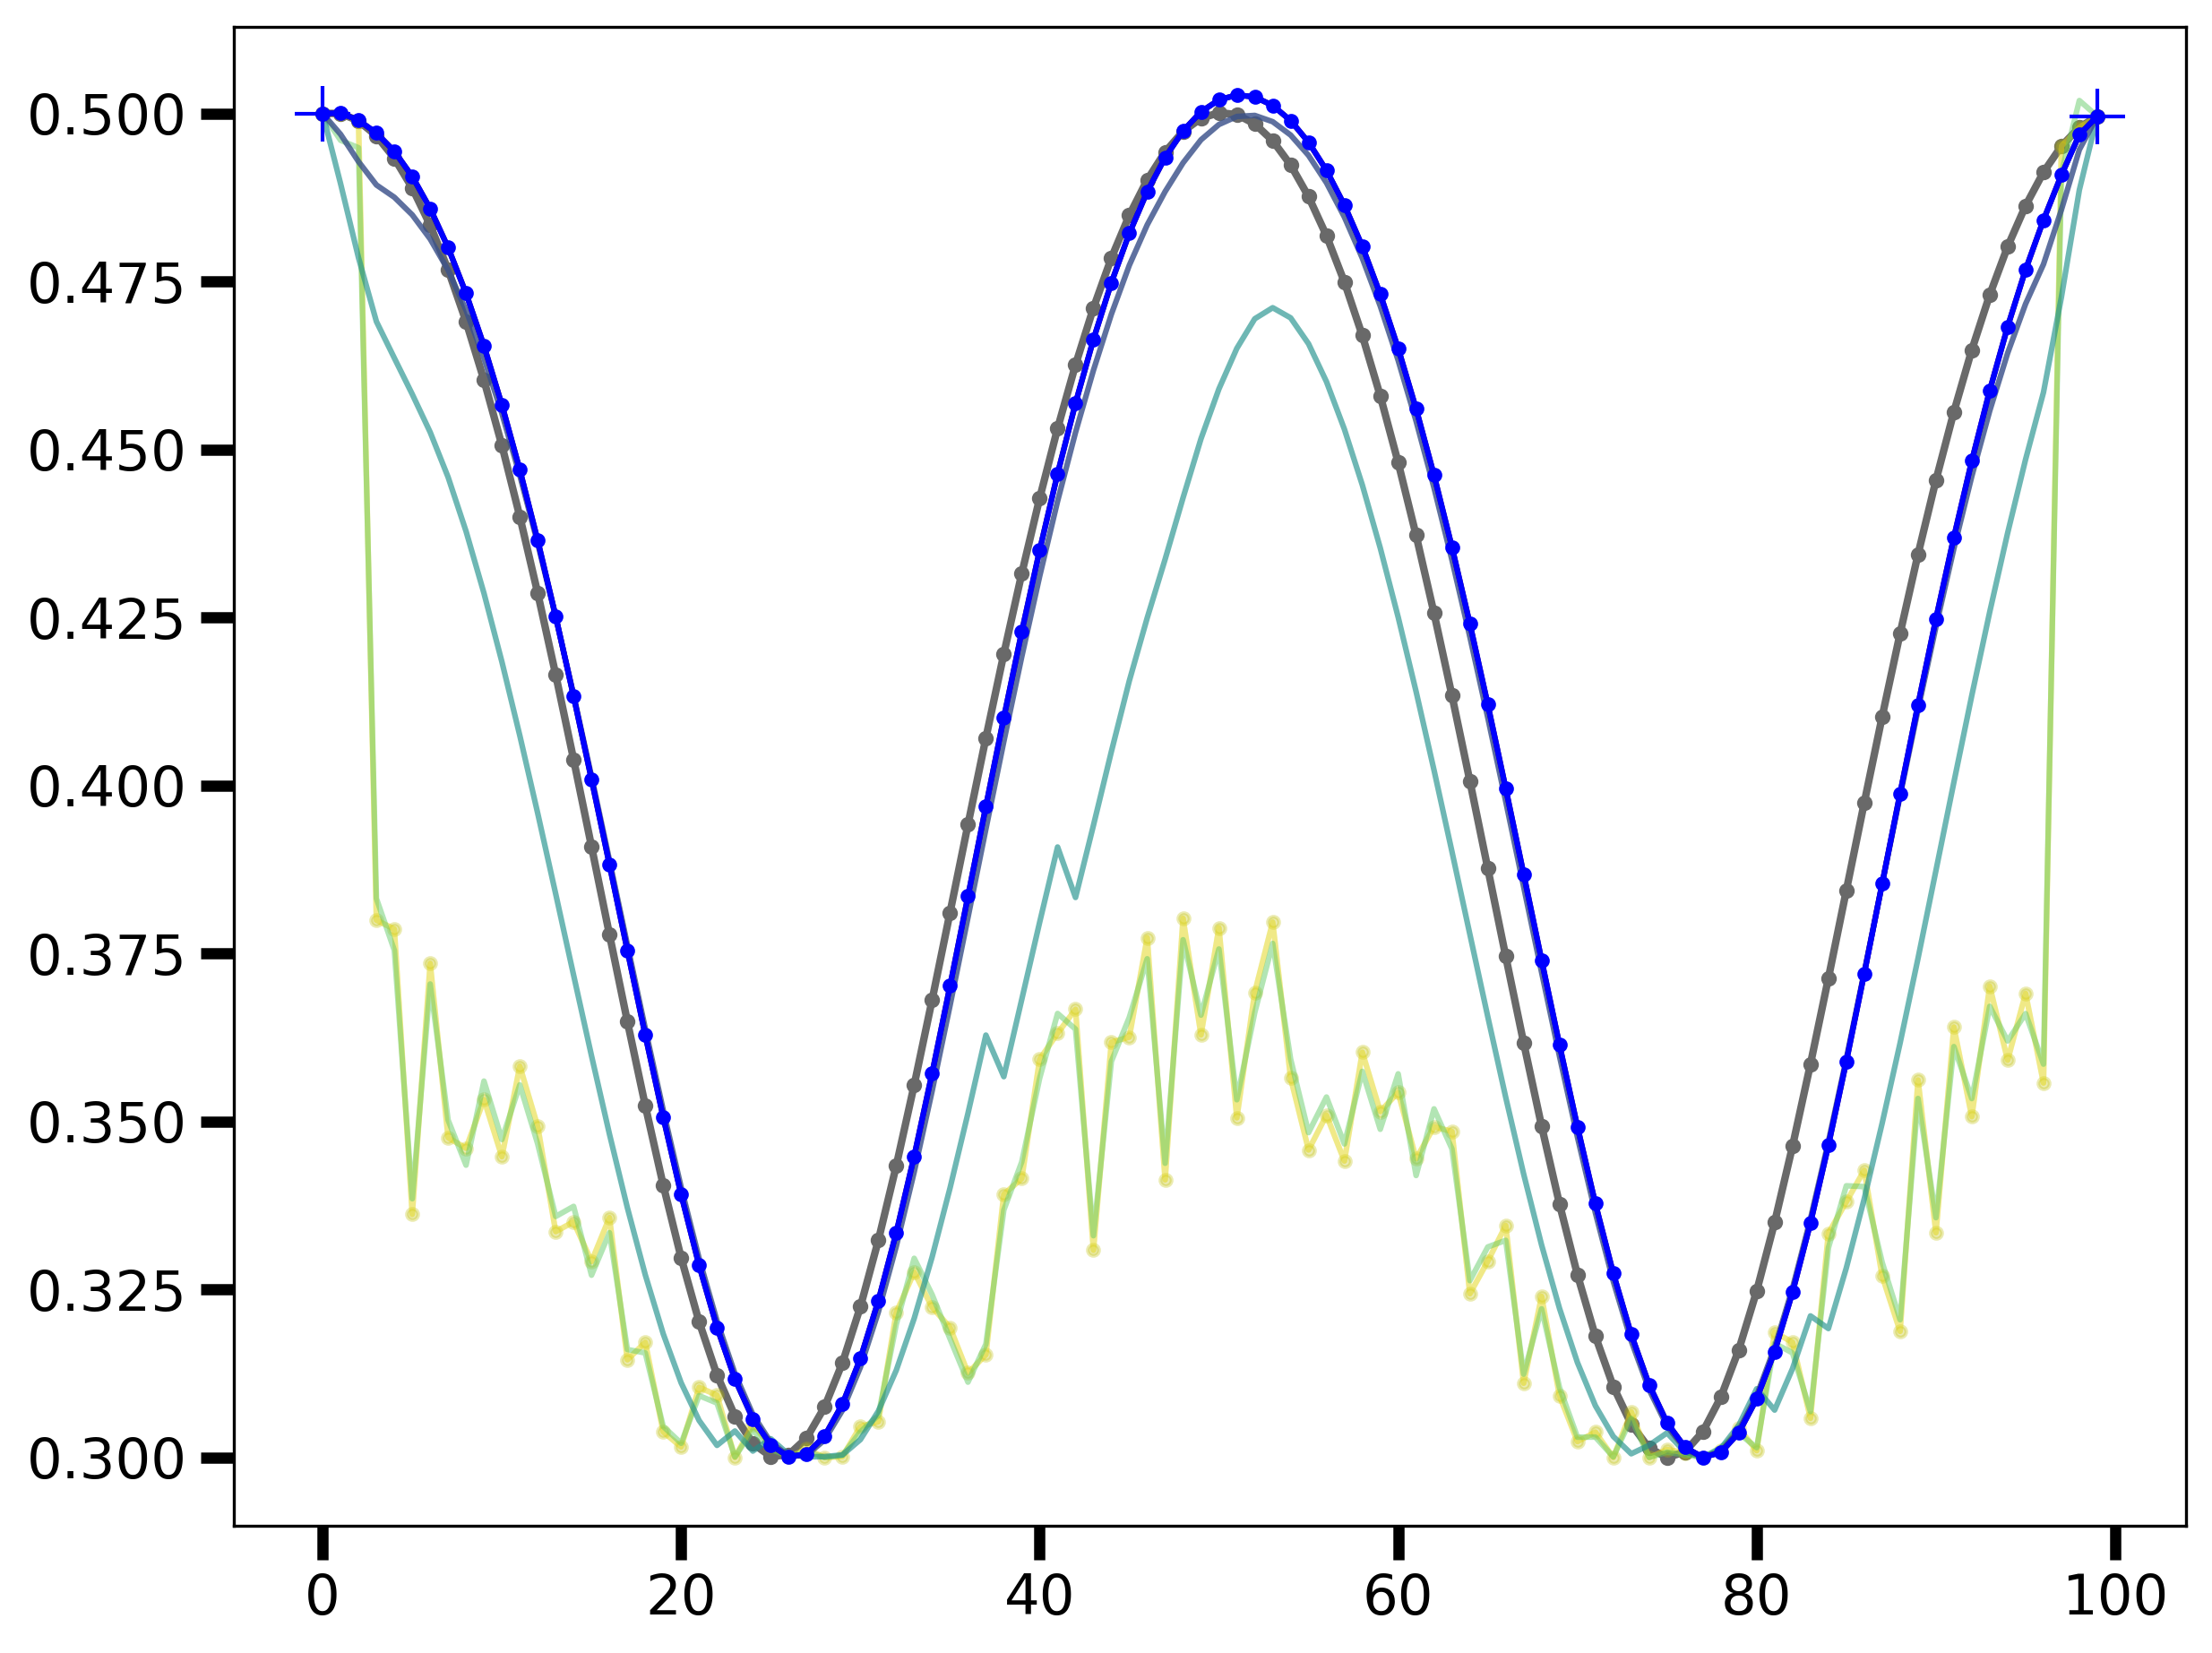

In [10]:
def pend_height(xs):
    return radial2cartesian_pend(xs)[...,1]

name = 'Pendulum'
fontsz = {'title': 19, 'x_label': 23, 'y_label': 23, 'legend': 10}
ax_labels = {'title':'Pendulum Height vs Time',
             'x_label':'Time (s)', 'y_label':'Height (m)'}

dynamic_plot(t_sim, x_sim, t_min, xs_min, name, fontsz, ax_labels, plt_fn=pend_height)

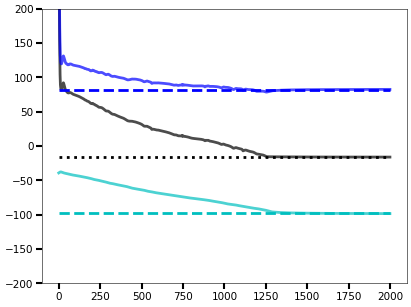

In [11]:
ax_labels = {'title':'Action and associated quantities ({})'.format(name),
                 'x_label':'Optimizer Steps', 'y_label':'J * s'}
fontsz = {'title': 18, 'x_label': 23, 'y_label': 28, 'legend': 10}
action_plot(info, x_sim, name, fontsz, ax_labels, L_fn=lagrangian_pend, ylim=(-200, 200))

## Double pendulum

In [12]:
dt = 0.06 ; N = 2
t_sim, x_sim = simulate_dblpend(dt=dt)
init_path = PerturbedPath(x_sim, N=N, coords=1, sigma=1e0, zero_basepath=False)
t_min, path, xs_min, info = minimize_action(init_path, steps=200, step_size=1e-1, 
                                            L_fn=lagrangian_dblpend, dt=dt, opt='adam', verbose=False)

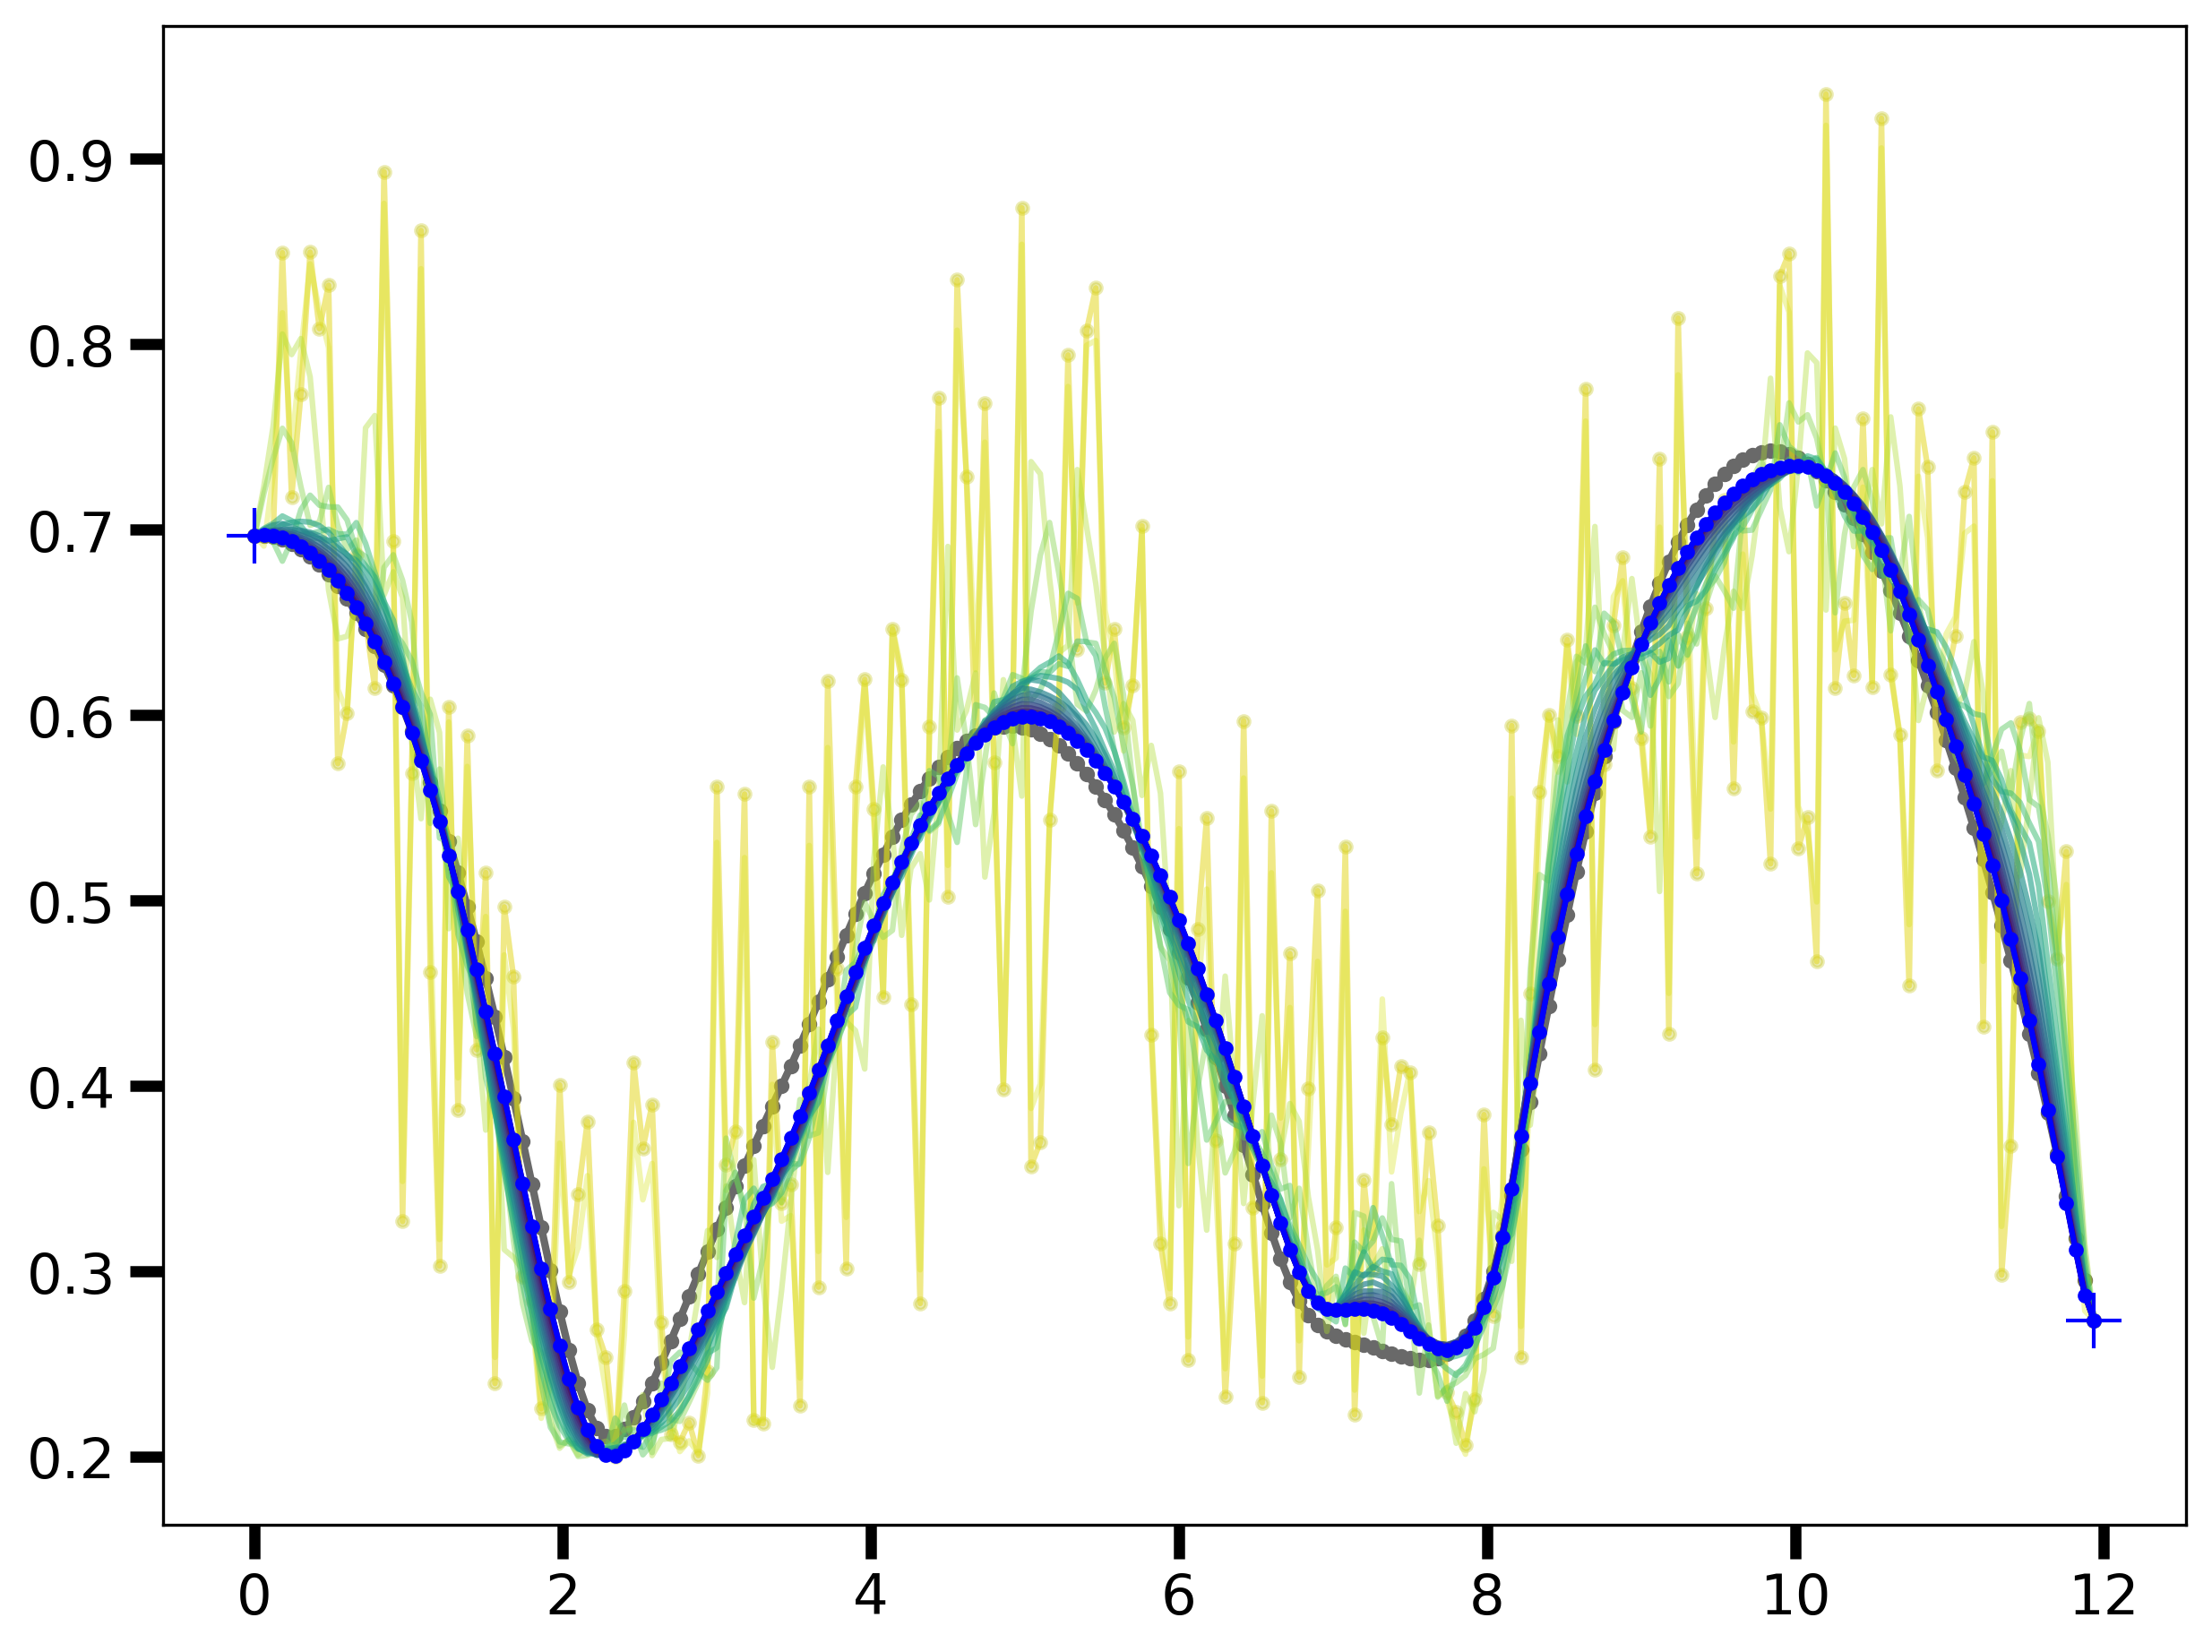

In [13]:
def dblpend_height(xs):
    return radial2cartesian_dblpend(xs)[:, 1, 1]

name = 'Double Pendulum'
fontsz = {'title': 19, 'x_label': 23, 'y_label': 23, 'legend': 10}
ax_labels = {'title':'Second Pendulum Height vs Time',
             'x_label':'Time (s)', 'y_label':'Height (m)'}

dynamic_plot(t_sim, x_sim, t_min, xs_min, name, fontsz, ax_labels, plt_fn=dblpend_height)

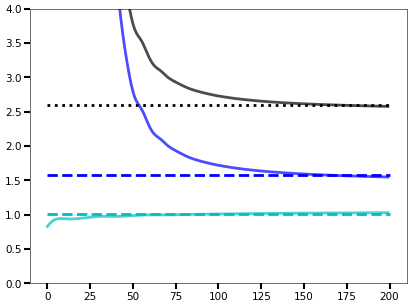

In [14]:
ax_labels = {'title':'Action and associated quantities ({})'.format(name),
                 'x_label':'Optimizer Steps', 'y_label':'J * s'}
fontsz = {'title': 16, 'x_label': 23, 'y_label': 28, 'legend': 10}
action_plot(info, x_sim, name, fontsz, ax_labels, L_fn=lagrangian_dblpend, ylim=(0, 4))

## Three body problem

In [15]:
dt = 0.5 ; N = 3
t_sim, x_sim = simulate_3body(dt=dt)
init_path = PerturbedPath(x_sim, N=N, sigma=2e-1) # [time, N*2]
t_min, path, xs_min, info = minimize_action(init_path, steps=125, step_size=1e-1,
                                       L_fn=lagrangian_3body, dt=dt, opt='adam')

step=0000, S=1.593e-01 J*s, E_loss=0.000e+00, dt=0.1s
step=0008, S=1.834e-02 J*s, E_loss=0.000e+00, dt=0.4s
step=0016, S=8.615e-03 J*s, E_loss=0.000e+00, dt=0.4s
step=0024, S=4.396e-03 J*s, E_loss=0.000e+00, dt=0.4s
step=0032, S=2.241e-03 J*s, E_loss=0.000e+00, dt=0.4s
step=0040, S=1.363e-03 J*s, E_loss=0.000e+00, dt=0.4s
step=0048, S=9.146e-04 J*s, E_loss=0.000e+00, dt=0.3s
step=0056, S=6.545e-04 J*s, E_loss=0.000e+00, dt=0.4s
step=0064, S=5.669e-04 J*s, E_loss=0.000e+00, dt=0.4s
step=0072, S=5.300e-04 J*s, E_loss=0.000e+00, dt=0.4s
step=0080, S=5.049e-04 J*s, E_loss=0.000e+00, dt=0.4s
step=0088, S=4.939e-04 J*s, E_loss=0.000e+00, dt=0.3s
step=0096, S=4.878e-04 J*s, E_loss=0.000e+00, dt=0.4s
step=0104, S=4.835e-04 J*s, E_loss=0.000e+00, dt=0.4s
step=0112, S=4.802e-04 J*s, E_loss=0.000e+00, dt=0.4s
step=0120, S=4.775e-04 J*s, E_loss=0.000e+00, dt=0.4s


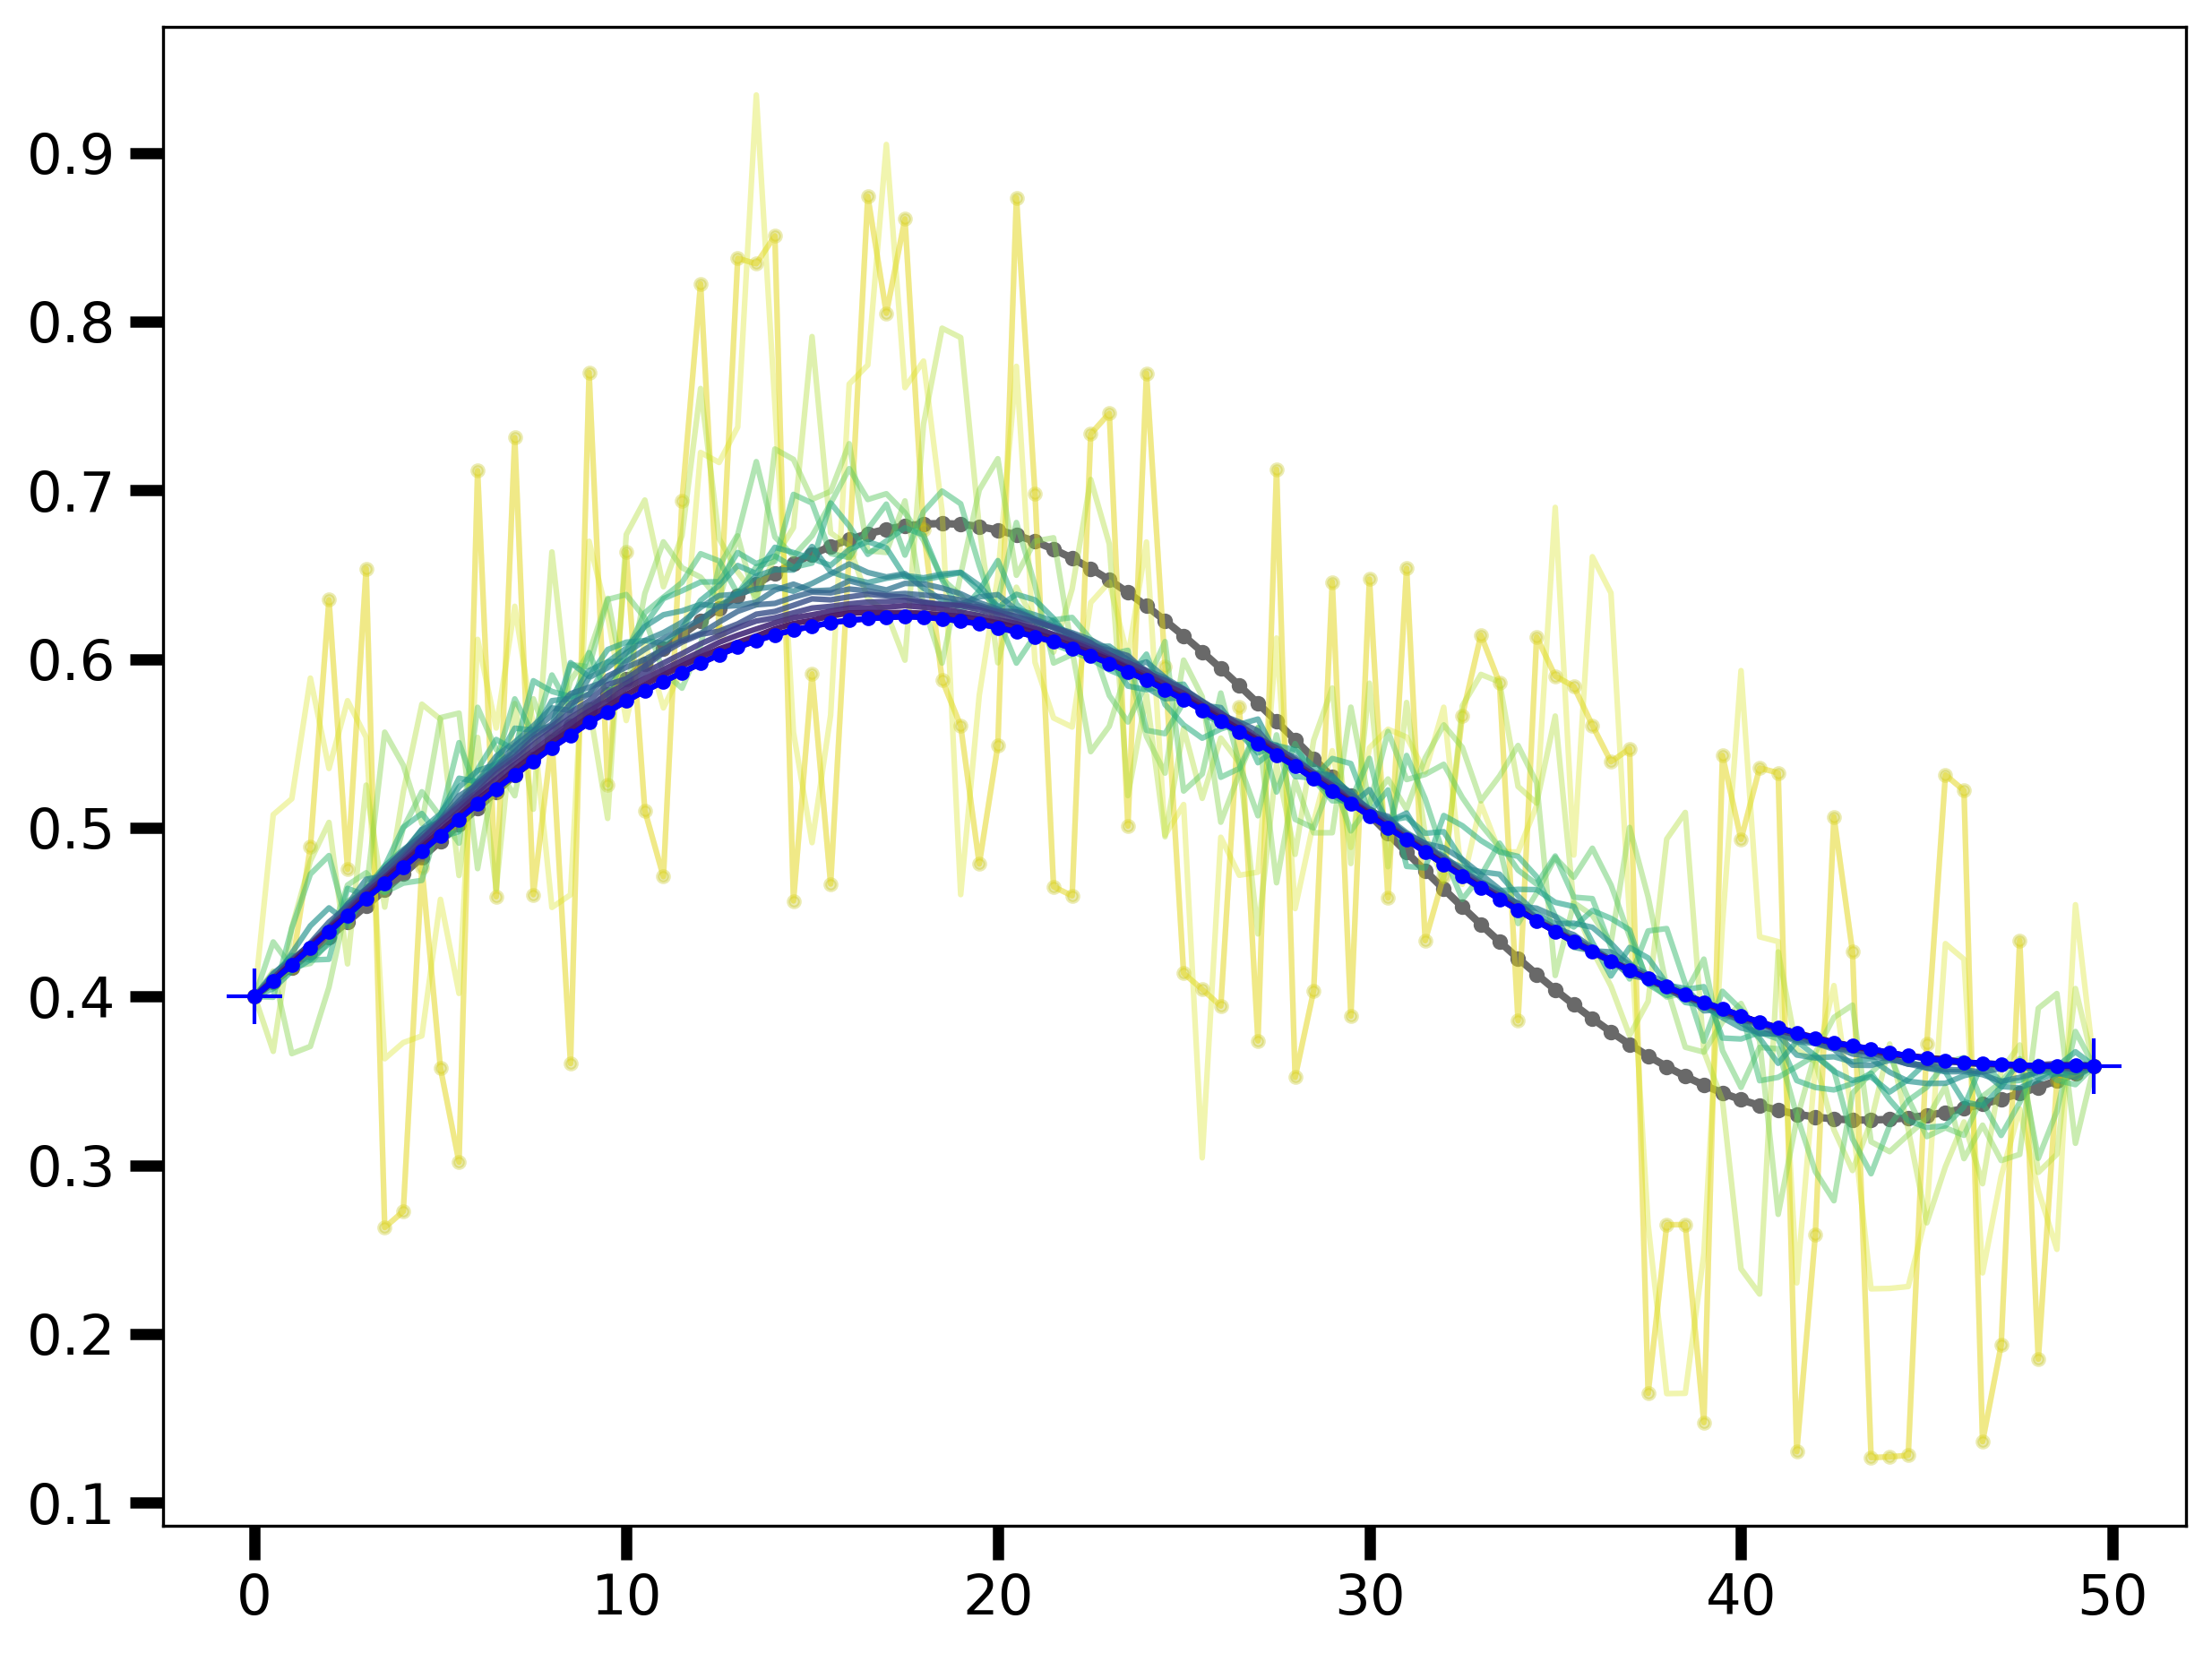

In [16]:
N = x_sim.shape[-2]
k=0
def ball_xcoord(xs, shape=x_sim.shape, k=k):
    return xs.reshape(shape)[:, 0, k]

name = 'Three body'
ax_labels = {'title':'Ball {} X-Coordinate vs. Time'.format(1 + k//2),
             'x_label':'Time (s)', 'y_label':'Position (m)'}
fontsz = {'title': 18, 'x_label': 23, 'y_label': 23, 'legend': 10}
dynamic_plot(t_sim, x_sim, t_min, xs_min, name, fontsz, ax_labels, plt_fn=ball_xcoord)

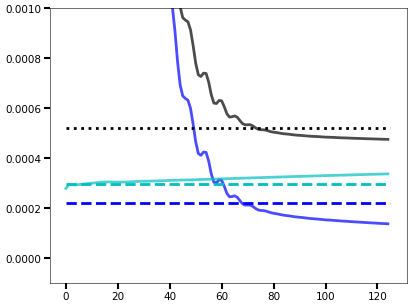

In [17]:
ax_labels = {'title':'Action and associated quantities ({})'.format(name),
                 'x_label':'Optimizer Steps', 'y_label':'J * s'}
fontsz = {'title': 16, 'x_label': 23, 'y_label': 28, 'legend': 10}
action_plot(info, x_sim, name, fontsz, ax_labels, L_fn=lagrangian_3body, ylim=(-.0001, .001))

## Gas simulation

In [ ]:
dt = 0.5 ; N = 50
t_sim, x_sim = simulate_gas(dt=dt, N=N)
init_path = PerturbedPath(x_sim, N=N, sigma=1e-3)
t_min, path, xs_min, info = minimize_action(init_path, steps=100, step_size=1e-2,
                                       L_fn=lagrangian_gas, dt=dt, opt='adam')

step=0000, S=-5.674e-04 J*s, E_loss=0.000e+00, dt=0.1s
step=0006, S=-4.279e-04 J*s, E_loss=0.000e+00, dt=0.5s
step=0012, S=-5.357e-04 J*s, E_loss=0.000e+00, dt=0.5s
step=0018, S=-5.642e-04 J*s, E_loss=0.000e+00, dt=0.5s


In [ ]:
name = 'Gas'
N = x_sim.shape[-2]
k = 30

def gas_xcoord(xs, N=N, k=k):
    return xs.reshape(-1,N*2)[...,k]

ax_labels = {'title':'Ball {} X-Coordinate vs. Time'.format(1 + k//2),
             'x_label':'Time (s)', 'y_label':'Position (m)'}
fontsz = {'title': 18, 'x_label': 23, 'y_label': 23, 'legend': 10}

dynamic_plot(t_sim, x_sim, t_min, xs_min, name, fontsz, ax_labels, plt_fn=gas_xcoord)

In [ ]:
ax_labels = {'title':'Action and associated quantities ({})'.format(name),
                 'x_label':'Optimizer Steps', 'y_label':'J * s'}
fontsz = {'title': 16, 'x_label': 23, 'y_label': 28, 'legend': 10}
fig = action_plot(info, x_sim, name, fontsz, ax_labels, L_fn=lagrangian_3body)

## Ephemeris dataset and simulation

In [ ]:
planets = ['sun', 'mercury', 'venus', 'earth', 'mars']
data_dir = './data/'
df = process_raw_ephemeris(planets, data_dir, last_n_days=365) #365

t_sim, x_sim = simulate_planets(df, planets)
plot_planets(df, planets)

colors = get_planet_colors()
for i, (planet, coords) in enumerate(zip(planets, x_sim.transpose(1,2,0))):
    x, y = coords
    plt.plot(x, y, ':', alpha=0.5, color=colors[planet], label=planets[i] + ' (sim)')
    plt.plot(x[0], y[0], '+', color=colors[planet])
    plt.plot(x[-1], y[-1], 'x', color=colors[planet])
plt.axis('equal')
plt.legend(fontsize=6,  loc='upper right', ncol=2) ; plt.show()

In [ ]:
dt = 24*60*60 ; N = len(planets)
df = process_raw_ephemeris(planets, data_dir, last_n_days=365)
t_sim, x_sim = simulate_planets(df, planets, dt=dt)
init_path = PerturbedPath(x_sim, N=N, sigma=2e10, is_ephemeris=True)

L_planets = partial(lagrangian_planets, masses=get_masses(planets))

t_min, path, xs_min, info = minimize_action(init_path, steps=500, step_size=1e9,
                                       L_fn=L_planets, dt=dt, opt='adam')

In [ ]:
def earth_ycoord(xs, N=N):
    return xs.reshape(-1,N,2)[:, 2, 1]

ax_labels = {'title':'Earth Y-Coordinate',
             'x_label':'Time (hr)', 'y_label':'Position (m)'}
fontsz = {'title': 18, 'x_label': 23, 'y_label': 23, 'legend': 10}
name = 'Ephemeris'

dynamic_plot(t_sim, x_sim, t_min, xs_min, name, fontsz, ax_labels, plt_fn=earth_ycoord)

In [ ]:
ax_labels = {'title':'Action and associated quantities ({})'.format(name),
                 'x_label':'Optimizer Steps', 'y_label':'J * s'}
fontsz = {'title': 16, 'x_label': 23, 'y_label': 28, 'legend': 10}
action_plot(info, x_sim, name, fontsz, ax_labels, L_fn=lagrangian_3body, ylim=(-1e33, .8e34))

In [ ]:
fig = plt.figure(figsize=[5,5], dpi=140)
plot_planets(df, planets, fig=fig)
colors = get_planet_colors()

xs = xs_min[0].detach().numpy().reshape(-1,N,2)
for i, (planet, coords) in enumerate(zip(planets, xs.transpose(1,2,0))):
    x, y = coords
    plt.plot(x, y, '.', alpha=0.3, color=colors[planet], label=planets[i] + ' (init)')
    plt.plot(x[0], y[0], '+', color=colors[planet])
    plt.plot(x[-1], y[-1], 'x', color=colors[planet])
    
xs = xs_min[-1].detach().numpy().reshape(-1,N,2)
for i, (planet, coords) in enumerate(zip(planets, xs.transpose(1,2,0))):
    x, y = coords
    plt.plot(x, y, ':', alpha=0.5, color=colors[planet], label=planets[i] + ' (path)')

plt.axis('equal')
plt.legend(fontsize=6,  loc='upper right', ncol=3) ; plt.show()